In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pink_utils as pu
import pandas as pd
import astropy.units as u
from tqdm import tqdm
from astropy.coordinates import SkyCoord, search_around_sky
from pink_utils import Annotation

In [2]:
FIRST_PIX = 1.8*u.arcsecond # Pixel size of FIRST survey. Square pixels
FIRST_FWHM = 5*u.arcsecond / FIRST_PIX
FIRST_SIG = FIRST_FWHM / 2.355

In [3]:
df        = pd.read_csv('../FIRST_F1W1_95_5_Sources.csv')
transform = pu.transform('../Small/FIRST_F1W1_95_5_Small_Transform.bin')
ed        = pu.heatmap('../Small/FIRST_F1W1_95_5_Small_Similarity.bin')
som       = pu.som('../Small/FIRST_F1W1_95_5_L1_SOM_Small_5.bin')
images    = pu.image_binary('../FIRST_F1W1_95_5_imgs.bin')

with open('../Small/FIRST_F1W1_95_5_L1_SOM_Small_5_Features-table.pkl','rb') as infile:
    annotations = pickle.load(infile)

In [4]:
print(som.file_head)
print(images.file_head)
print(transform.file_head)
print(ed.file_head)
print(df.shape)
NEURON_SIZE = som.file_head[-1] # Equal dimensions 

(2, 12, 12, 1, 118, 118)
(178859, 2, 167, 167)
(178859, 12, 12, 1)
(178859, 12, 12, 1)
(178859, 29)


/Users/gal16b/miniconda3/envs/pink_e3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/gal16b/miniconda3/envs/pink_e3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


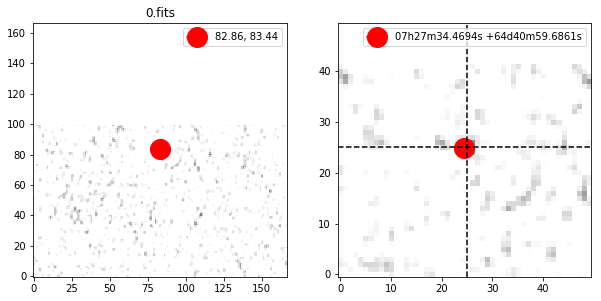

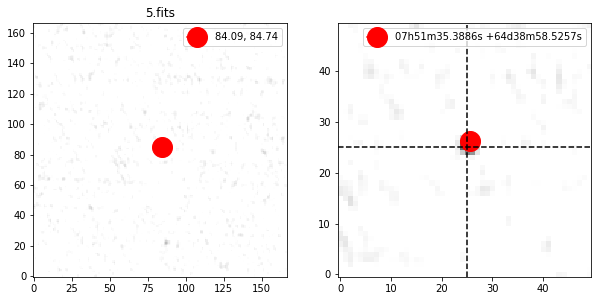

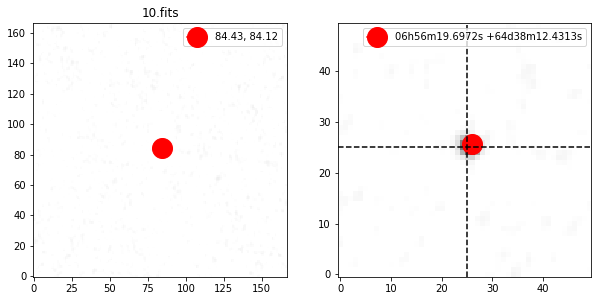

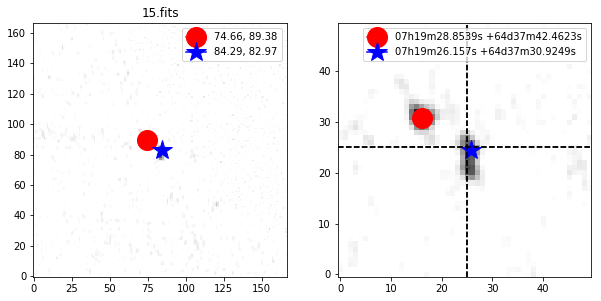

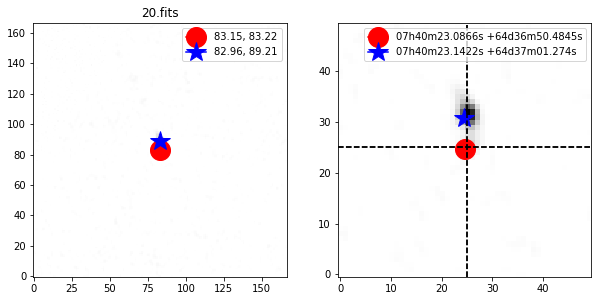

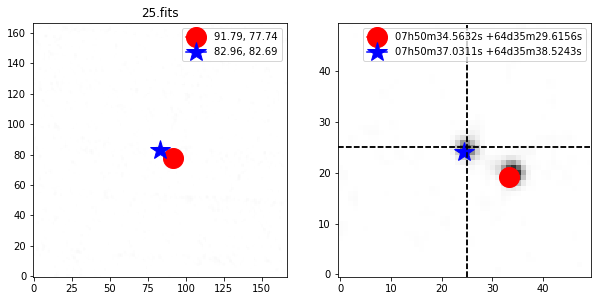

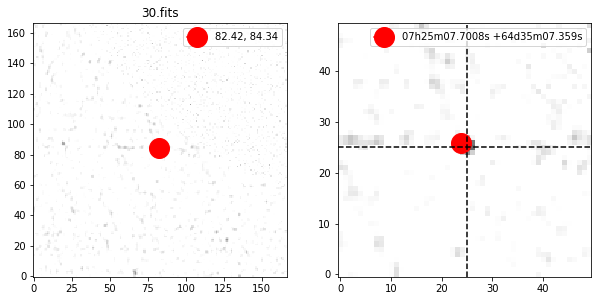

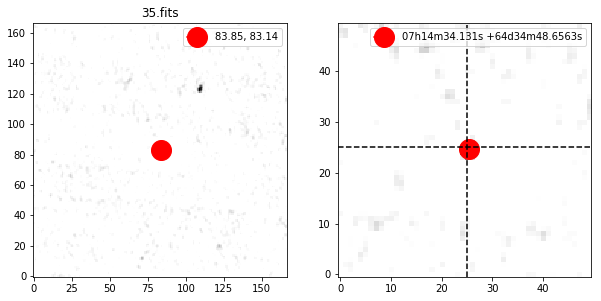

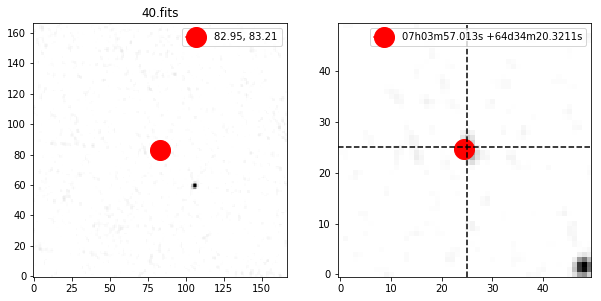

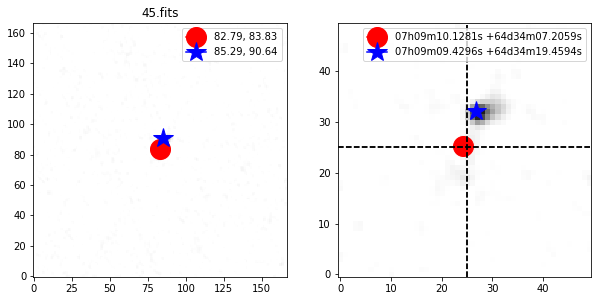

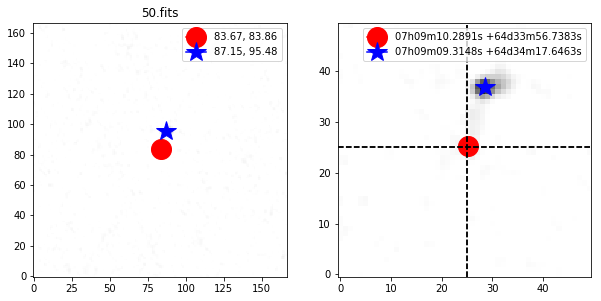

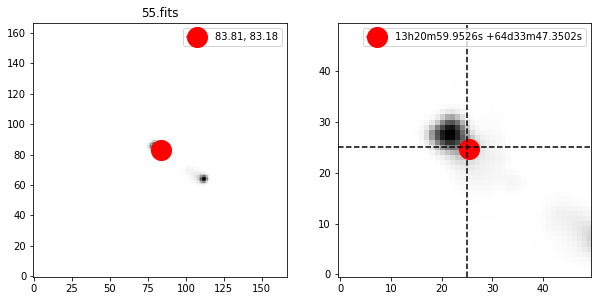

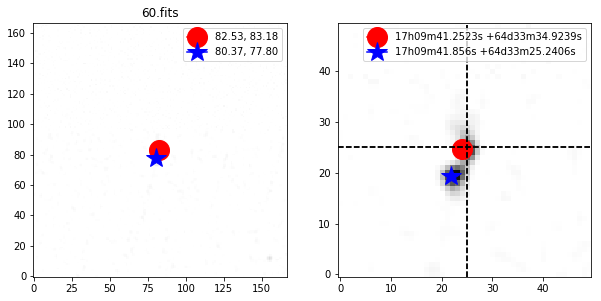

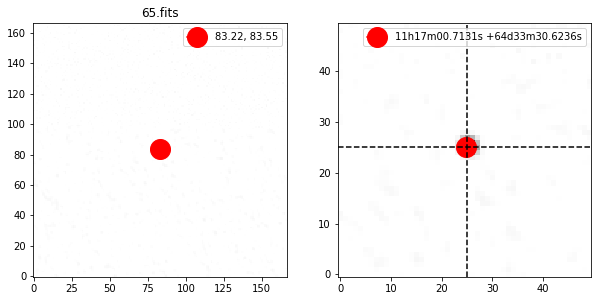

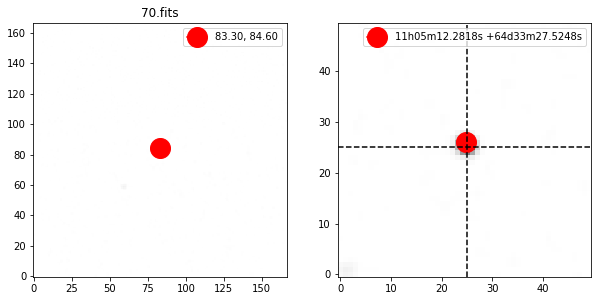

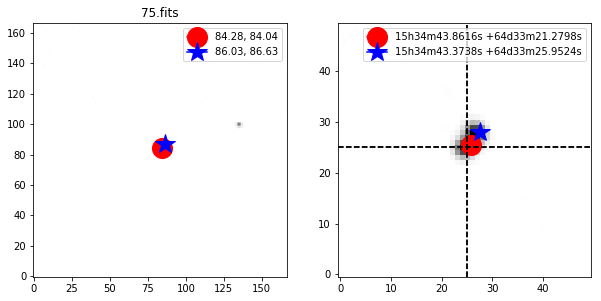

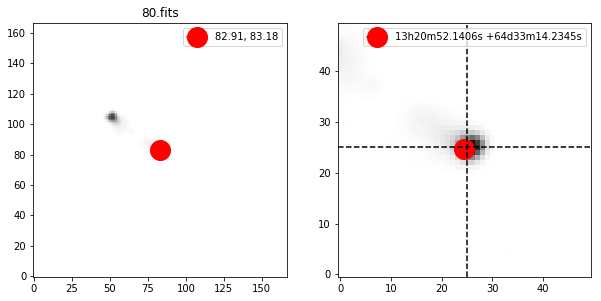

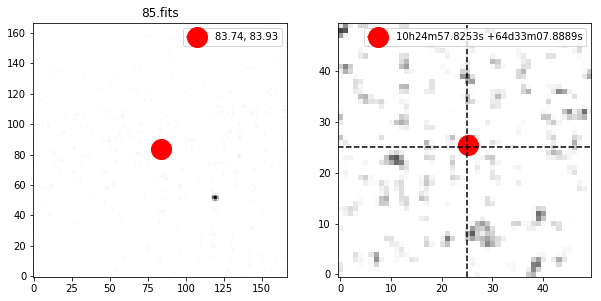

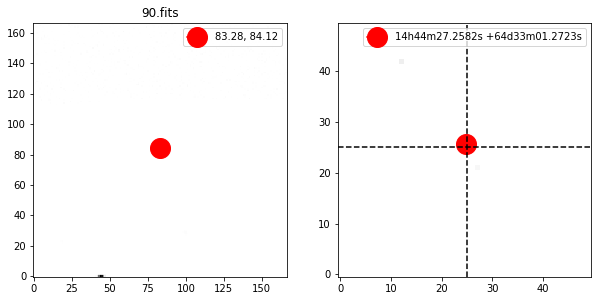

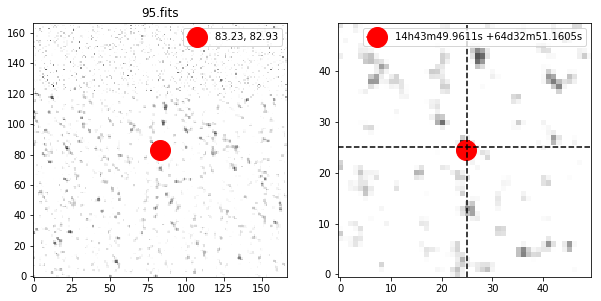

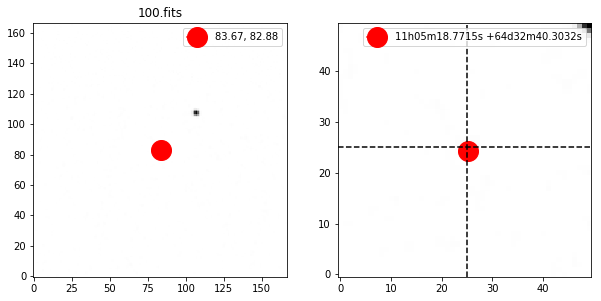

In [5]:
plt.close('all')

ms = ['o','*','>']
c  = ['red', 'blue', 'black']
cmap = 'Greys'

for (count, (index, row)) in enumerate(df.iterrows()):

    if count != index:
        print('Mistmatch', index, count)
    
    # Limit reached lets move on
    if index > 20:
        break
        
    cen_pos = SkyCoord(ra=row['RA']*u.deg, dec=row['DEC']*u.deg)
    
    bmu_pos    = ed.get_bmu(index)
    trans_info = transform.get_neuron_transform(index, bmu_pos)
    
    # Annotate_map_features.py script recorded positions around the 
    # incorrect convention
    key = (bmu_pos[1], bmu_pos[0]) + (0,)
    bmu = annotations[key]
    
    # Transform annotated clicks 
    r_feature_trans  = bmu.transform_clicks(trans_info, channel=0)
    ir_feature_trans = bmu.transform_clicks(trans_info, channel=1)
    
    radio_img = np.arcsinh(images.get_image(index=index, channel=0))
    
    fig, (ax, ax1) = plt.subplots(1,2, figsize=(10,5))
    
    ax.imshow(radio_img, origin='lower left', cmap=cmap)
    cen = np.array(radio_img.shape)/2
    
    zoom_rad = pu.zoom(radio_img, 50, 50)
    ax1.imshow(zoom_rad, origin='lower left', cmap=cmap)
    zoom_cen = np.array(zoom_rad.shape)/2
    
    for click, radio in enumerate(r_feature_trans):
        dx, dy = radio
        comp_pos = pu.estimate_position(cen_pos, dx, dy, pix_scale=FIRST_PIX)

        ax.plot(dx+cen[0], dy+cen[1], color=c[click], marker=ms[click], markersize=20, label=f"{dx+cen[0]:.2f}, {dy+cen[1]:.2f}")
        ax.legend(loc='best')
        
        ax1.plot(dx+zoom_cen[0], dy+zoom_cen[1], color=c[click], marker=ms[click], markersize=20, label=f"{comp_pos.to_string('hmsdms')}")
        ax1.legend(loc='best')
        ax1.axhline(zoom_cen[0], ls='--', color='black')
        ax1.axvline(zoom_cen[1], ls='--', color='black')

    ax.set_title(row['filename'])
    fig.show()

In [6]:
plt.close('all')

class PredictionSet():
    """Class to accept predicted positions to cross match with
    """
    def __init__(self, pos: list, uid: int, row: pd.Series, index: int):
        """Create new instance
        
        pos ({list}) -- List (or list like) of SkyCoord positions
        uid ({int}) -- Unique numeric (or hashable) identifier
        row ({pd.Series}) -- Row of the centred source clicks are generated for
        index ({int}) -- Index of the `row` taken from 
        """
        self.pos = pos
        self.uid = uid
        self.cat = SkyCoord(ra=[i.ra for i in pos], dec=[i.dec for i in pos])
        self.mean_pos = SkyCoord(ra=self.cat.ra.mean(), dec=self.cat.dec.mean())
        self.link_id = None
        self.row = row

        

ms = ['o','*','>']
c  = ['red', 'blue', 'black']
cmap = 'Greys'
predictions = []

for (count, (index, row)) in tqdm(enumerate(df.iterrows())):

    if count != index:
        print('Mistmatch', index, count)
    
    # Limit reached lets move on
    if index > 50000:
        break
        
    cen_pos = SkyCoord(ra=row['RA']*u.deg, dec=row['DEC']*u.deg)
    
    bmu_pos    = ed.get_bmu(index)
    trans_info = transform.get_neuron_transform(index, bmu_pos)
    
    # Annotate_map_features.py script recorded positions around the 
    # incorrect convention
    key = (bmu_pos[1], bmu_pos[0]) + (0,)
    bmu = annotations[key]
    
    # Transform annotated clicks 
    r_feature_trans  = bmu.transform_clicks(trans_info, channel=0)
    ir_feature_trans = bmu.transform_clicks(trans_info, channel=1)
    
    positions = []
    for click, radio in enumerate(r_feature_trans):
        dx, dy = radio
        comp_pos = pu.estimate_position(cen_pos, dx, dy, pix_scale=FIRST_PIX)
        
        positions.append(comp_pos)
        
    predict = PredictionSet(positions, len(predictions) + 1, row, index)
    predictions.append(predict)

50000it [15:24, 51.84it/s]

In [7]:
MASTER_ID = 0
RADIUS = 15*u.arcsecond
MAJOR_RADIUS = 5 * u.arcminute

def get_new_id():
    global MASTER_ID
    MASTER_ID = MASTER_ID + 1
    
    return MASTER_ID

mean_positions = SkyCoord(ra=[i.mean_pos.ra for i in predictions], 
                          dec=[i.mean_pos.dec for i in predictions])
mean_results = search_around_sky(mean_positions, mean_positions, seplimit=MAJOR_RADIUS)

print(mean_results[0].shape)
print(mean_results)

50000it [15:41, 51.84it/s]

(75259,)
(array([    0,     1,     2, ..., 49999, 49999, 50000]), array([    0,     1,     2, ..., 49961, 49999, 50000]), <Angle [0.        , 0.        , 0.        , ..., 0.05007625, 0.        ,
        0.        ] deg>, <Quantity [0.      , 0.      , 0.      , ..., 0.000874, 0.      , 0.      ]>)


In [8]:
len(predictions)

50001

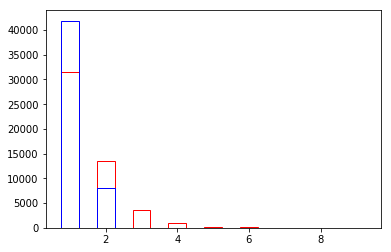

In [9]:
from collections import Counter

counts = Counter(mean_results[0])
grp_counts = Counter(counts.values())
list_counts = Counter([len(i.pos) for i in predictions])

fig, ax = plt.subplots(1,1)

ax.bar(grp_counts.keys(), grp_counts.values(), width=0.5, fill=False, edgecolor='red')
ax.bar(list_counts.keys(), list_counts.values(), width=0.5, fill=False, edgecolor='blue')


fig.show()

In [10]:
from collections import defaultdict

class Linker():
    idd = 0
    def __init__(self):
        self.lookup = {}
        self.table = defaultdict(list)
       
    def new_id(self):
        idd = self.idd
        self.idd += 1
        
        return idd
        
        
    def add_single_object(self, pred_1):
        idx_pred_1 = self.lookup[pred_1] if pred_1 in self.lookup.keys() else None
        if idx_pred_1 is None:
            idd = self.new_id()
            
            self.lookup[pred_1] = idd
            self.table[idd].append(pred_1)
            
            return
        else:
            # Nothing to do?
#             print('There is nothing to do?')
            return
        
        
    def add_predition(self, pred_1, pred_2):
        if pred_2 is None:
            self.add_single_object(pred_1)
            return
        
        idx_pred_1 = self.lookup[pred_1] if pred_1 in self.lookup.keys() else None
        idx_pred_2 = self.lookup[pred_2] if pred_2 in self.lookup.keys() else None
        
        if idx_pred_1 is None and idx_pred_2 is None:
            idd = self.new_id()
            self.table[idd].append(pred_1)
            self.table[idd].append(pred_2)
            self.lookup[pred_1] = idd
            self.lookup[pred_2] = idd    
            print('Emptyyy')
            return
        
        elif idx_pred_1 is not None and idx_pred_2 is None:
            idd = self.lookup[pred_1]
            self.lookup[pred_2] = idd
            self.table[idd].append(pred_2)
            
            return
        
        elif idx_pred_2 is not None and idx_pred_1 is None:
            idd = self.lookup[pred_2]
            self.lookup[pred_1] = idd
            self.table[idd].append(pred_1)
            return
        
        elif idx_pred_1 is not None and idx_pred_2 is not None:
            idd_1 = self.lookup[pred_1]
            idd_2 = self.lookup[pred_2]
        
            if idd_1 == idd_2:
                # do nothing as they are already linked?
#                 print('Here', pred_1, pred_2)
                return
            
            else:
                idd = self.new_id()
                
                list_1 = self.table[idd_1]
                list_2 = self.table[idd_2]
                                
                list_idd = list(set(list_1 + list_2))
                
                self.table[idd].extend(list_idd)
        
                for p in list_idd:
                    self.lookup[p] = idd
                
                self.table.pop(idd_1)
                self.table.pop(idd_2)
        

links = Linker()

for pidx1, pidx2 in tqdm(zip(mean_results[0], mean_results[1])):
    if pidx1 == pidx2:
        ps1 = predictions[pidx1]
        links.add_predition(ps1, None)
    else:
        ps1 = predictions[pidx1]
        ps2 = predictions[pidx2]

        comp = search_around_sky(ps1.cat, ps2.cat, seplimit=RADIUS)
#         print(comp)
        if len(comp[0]) > 1:
            links.add_predition(ps1, ps2)

print('Done')


0it [00:00, ?it/s]
48it [00:00, 479.42it/s]
93it [00:00, 465.67it/s]
171it [00:00, 527.89it/s]
237it [00:00, 558.12it/s]
290it [00:00, 547.91it/s]
339it [00:00, 505.67it/s]
405it [00:00, 538.35it/s]
473it [00:00, 572.33it/s]
533it [00:00, 573.73it/s]
590it [00:01, 500.73it/s]
652it [00:01, 531.10it/s]
726it [00:01, 573.24it/s]
786it [00:01, 559.58it/s]
856it [00:01, 588.74it/s]
917it [00:01, 591.13it/s]
996it [00:01, 633.22it/s]
1061it [00:01, 630.82it/s]
1126it [00:01, 623.89it/s]
1190it [00:02, 592.54it/s]
1251it [00:02, 533.02it/s]
1307it [00:02, 471.89it/s]
1357it [00:02, 360.28it/s]
1399it [00:02, 348.18it/s]
1448it [00:02, 377.61it/s]
1502it [00:02, 413.73it/s]
1547it [00:03, 377.56it/s]
1614it [00:03, 430.75it/s]
1662it [00:03, 428.20it/s]
1714it [00:03, 449.94it/s]
1787it [00:03, 506.73it/s]
1842it [00:03, 465.82it/s]
1893it [00:03, 406.88it/s]
1944it [00:03, 427.99it/s]
2000it [00:03, 457.86it/s]
2049it [00:04, 382.54it/s]
2092it [00:04, 362.63it/s]
2132it [00:04, 311.58it/s]

15414it [00:30, 544.80it/s]
15473it [00:30, 533.01it/s]
15529it [00:30, 535.90it/s]
15585it [00:30, 514.71it/s]
15638it [00:30, 474.35it/s]
15688it [00:31, 433.87it/s]
15744it [00:31, 465.24it/s]
15793it [00:31, 455.67it/s]
15840it [00:31, 457.84it/s]
15888it [00:31, 462.02it/s]
15962it [00:31, 519.10it/s]
16025it [00:31, 541.06it/s]
16097it [00:31, 578.57it/s]
16158it [00:31, 568.55it/s]
16217it [00:32, 542.82it/s]
16273it [00:32, 480.55it/s]
16330it [00:32, 501.91it/s]
16383it [00:32, 504.57it/s]
16439it [00:32, 518.82it/s]
16492it [00:32, 484.19it/s]
16557it [00:32, 522.95it/s]
16612it [00:32, 513.33it/s]
16684it [00:32, 558.79it/s]
16742it [00:33, 549.36it/s]
16811it [00:33, 581.40it/s]
16872it [00:33, 587.57it/s]
16932it [00:33, 537.94it/s]
16988it [00:33, 534.03it/s]
17043it [00:33, 520.53it/s]
17102it [00:33, 533.72it/s]
17157it [00:33, 501.69it/s]
17209it [00:33, 482.03it/s]
17282it [00:34, 533.09it/s]
17338it [00:34, 496.66it/s]
17390it [00:34, 484.20it/s]
17441it [00:34, 491.

30250it [01:00, 531.45it/s]
30308it [01:00, 541.38it/s]
30364it [01:00, 504.77it/s]
30416it [01:00, 439.61it/s]
30470it [01:00, 461.09it/s]
30521it [01:00, 470.17it/s]
30586it [01:00, 507.40it/s]
30639it [01:01, 502.31it/s]
30692it [01:01, 509.17it/s]
30747it [01:01, 515.24it/s]
30809it [01:01, 542.41it/s]
30884it [01:01, 588.20it/s]
30968it [01:01, 640.94it/s]
31035it [01:01, 634.96it/s]
31101it [01:01, 616.95it/s]
31165it [01:01, 541.55it/s]
31222it [01:02, 434.34it/s]
31271it [01:02, 437.25it/s]
31319it [01:02, 434.38it/s]
31368it [01:02, 447.40it/s]
31415it [01:02, 450.43it/s]
31466it [01:02, 464.77it/s]
31534it [01:02, 509.49it/s]
31593it [01:02, 527.52it/s]
31649it [01:02, 530.79it/s]
31707it [01:03, 542.12it/s]
31763it [01:03, 507.76it/s]
31815it [01:03, 483.03it/s]
31865it [01:03, 482.44it/s]
31914it [01:03, 475.99it/s]
31972it [01:03, 498.28it/s]
32028it [01:03, 506.39it/s]
32086it [01:03, 520.95it/s]
32139it [01:03, 508.60it/s]
32191it [01:04, 480.49it/s]
32240it [01:04, 479.

45137it [01:29, 442.72it/s]
45192it [01:30, 466.60it/s]
45240it [01:30, 462.26it/s]
45287it [01:30, 431.72it/s]
45339it [01:30, 451.50it/s]
45388it [01:30, 455.68it/s]
45437it [01:30, 461.91it/s]
45496it [01:30, 491.82it/s]
45547it [01:30, 462.99it/s]
45595it [01:30, 455.25it/s]
45653it [01:31, 484.10it/s]
45703it [01:31, 475.90it/s]
45756it [01:31, 486.11it/s]
45813it [01:31, 502.91it/s]
45871it [01:31, 518.49it/s]
45924it [01:31, 485.52it/s]
45974it [01:31, 459.11it/s]
46028it [01:31, 476.69it/s]
46097it [01:31, 519.21it/s]
46151it [01:32, 482.94it/s]
46213it [01:32, 514.69it/s]
46267it [01:32, 498.33it/s]
46330it [01:32, 521.59it/s]
46384it [01:32, 434.77it/s]
46431it [01:32, 440.48it/s]
46478it [01:32, 422.60it/s]
46524it [01:32, 430.57it/s]
46569it [01:33, 434.95it/s]
46614it [01:33, 411.43it/s]
46671it [01:33, 448.14it/s]
46723it [01:33, 464.78it/s]
46771it [01:33, 459.92it/s]
46833it [01:33, 493.71it/s]
46899it [01:33, 527.74it/s]
46954it [01:33, 525.88it/s]
47018it [01:33, 549.

59952it [01:59, 585.21it/s]
60013it [01:59, 555.29it/s]
60070it [01:59, 532.73it/s]
60125it [01:59, 535.27it/s]
60188it [01:59, 554.91it/s]
60256it [01:59, 578.29it/s]
60331it [01:59, 619.27it/s]
60395it [02:00, 569.13it/s]
60460it [02:00, 585.99it/s]
60520it [02:00, 510.84it/s]
60574it [02:00, 512.53it/s]
60628it [02:00, 476.35it/s]
60681it [02:00, 488.62it/s]
60732it [02:00, 457.77it/s]
60786it [02:00, 473.26it/s]
60835it [02:01, 449.30it/s]
60886it [02:01, 460.80it/s]
60946it [02:01, 489.61it/s]
60996it [02:01, 456.80it/s]
61043it [02:01, 454.58it/s]
61100it [02:01, 482.24it/s]
61154it [02:01, 494.01it/s]
61205it [02:01, 473.25it/s]
61254it [02:01, 447.55it/s]
61304it [02:02, 461.19it/s]
61366it [02:02, 493.09it/s]
61430it [02:02, 527.26it/s]
61490it [02:02, 540.36it/s]
61551it [02:02, 554.54it/s]
61608it [02:02, 552.64it/s]
61664it [02:02, 493.46it/s]
61719it [02:02, 505.04it/s]
61795it [02:02, 560.21it/s]
61854it [02:03, 545.07it/s]
61913it [02:03, 553.11it/s]
61970it [02:03, 540.

74654it [02:28, 575.66it/s]
74728it [02:28, 615.01it/s]
74795it [02:29, 624.48it/s]
74859it [02:29, 587.96it/s]
74927it [02:29, 608.12it/s]
74989it [02:29, 607.55it/s]
75051it [02:29, 558.51it/s]
75115it [02:29, 573.44it/s]
75174it [02:29, 542.36it/s]
75259it [02:29, 502.46it/s]

Done


In [11]:
links.table

defaultdict(list,
            {0: [<__main__.PredictionSet at 0xb673c1588>],
             1: [<__main__.PredictionSet at 0xb67593198>],
             2: [<__main__.PredictionSet at 0xb2b0e2278>],
             3: [<__main__.PredictionSet at 0xb729bbcc0>],
             4: [<__main__.PredictionSet at 0xb729c25f8>],
             5: [<__main__.PredictionSet at 0xb729c0828>],
             6: [<__main__.PredictionSet at 0x107ee1b38>],
             7: [<__main__.PredictionSet at 0x107ed2eb8>],
             8: [<__main__.PredictionSet at 0x107edaf98>],
             9: [<__main__.PredictionSet at 0x107ed10f0>,
             10: [<__main__.PredictionSet at 0x107ebee80>],
             11: [<__main__.PredictionSet at 0x107ec3cf8>],
             12: [<__main__.PredictionSet at 0x107ec1ac8>],
             13: [<__main__.PredictionSet at 0x107eb4f60>],
             14: [<__main__.PredictionSet at 0x107edaf28>],
             15: [<__main__.PredictionSet at 0x107eb5d30>],
             16: [<__main__.Predi

In [12]:
from collections import Counter

a = Counter([len(v) for k, v in links.table.items()])

In [13]:
a

Counter({1: 48331, 2: 777, 3: 36, 4: 2})

In [15]:
777/50000 * 100

1.554